In [2]:
import urllib.request
url = ("https://raw.githubusercontent.com/rasbt/"
       "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
       "the-verdict.txt")
file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x7db4bd5a74d0>)

In [25]:
%%writefile SimpleTokenizer.py 
from pydantic import validate_call, FilePath
import re

class SimpleTokenizer:
    
    @validate_call
    def __init__(self, file_path: FilePath) -> None:
        with open(file_path, "r") as f:
            txt = f.read()
            txt = re.findall(r"\w+|[^\w\s]", txt)
            txt += ["<|unk|>", "<|endoftext|>"]
            vocabs_dict = dict(enumerate(set(txt)))

        self.int2str = vocabs_dict
        self.str2int = {v: i for i, v in vocabs_dict.items()}
    
    @validate_call
    def encode(self, txt: str) -> list[int]:
        return [self.str2int.get(token) for token in txt.split() + ["<|endoftext|>"]]
    
    @validate_call
    def decode(self, token_ids: list[int]) -> str:
        return " ".join([self.int2str.get(id, "<|unk|>") for id in token_ids])


#example usage
o = SimpleTokenizer(file_path="the-verdict.txt")
ids = o.encode("How are you there")
o.decode(ids)

Overwriting SimpleTokenizer.py


In [ ]:
# the following is a note about working with pytorch dataloader:

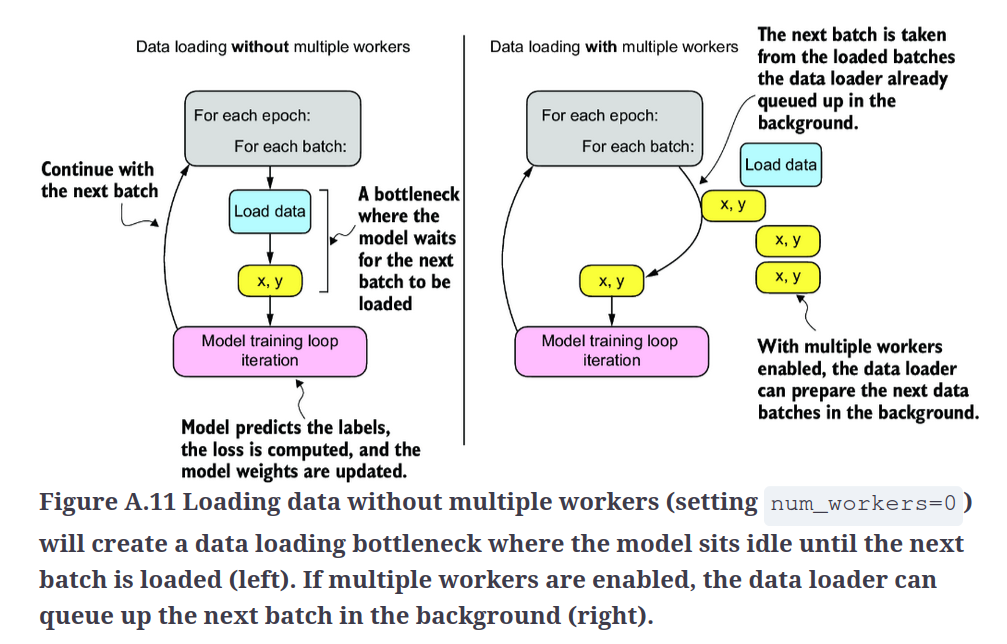

In [1]:
import tiktoken 

tokenizer = tiktoken.get_encoding('gpt2')
type(tokenizer)



tiktoken.core.Encoding

In [2]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(tokenizer.decode(integers))
print(tokenizer.n_vocab)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.
50257


In [8]:
text = "I am developing an LLM from scratch following guidance from book Building LLM from scratch"

with open("omar.txt",'w') as f:
    f.write(text)

print(tokenizer.n_vocab)

50257


In [2]:
%%writefile python_scripts/data_processor.py
# this file contains three classes:
# 1. GPT2Dataset: that wraps the text to Dataset object
# 2. GPT2DataLoader: that wraps the text to Dataloader object
# 3. GPT2ProcessorPipeLine: that build the dataset and dataloader and then return the embedding after passing the embedding weights.

import tiktoken, torch
from torch.utils.data import Dataset, DataLoader
from pydantic import FilePath

BPE_tokenizer = tiktoken.get_encoding('gpt2')

#-----------------------------------------------------------------------------#
class GPT2Dataset(Dataset):
    def __init__(self, txt_file: FilePath, tokenizer: tiktoken.core.Encoding = BPE_tokenizer,
                 max_length: int = 256, stride: int = 256):

        with open(txt_file,'r') as f:
            data_txt = f.read()
            data_ids =  tokenizer.encode(data_txt)

        self.vocab_size = tokenizer.n_vocab
        
        # This is to handle text size smaller than max-length ... 
        # -1 here because we depend on the smaller size which is the target not the input_ids
        max_length = len(data_ids)-1 if (len(data_ids) < max_length) else max_length

        self.input_ids = []
        self.target_ids = []

        for i in range(0,len(data_ids)-max_length,stride):
            self.input_ids.append(data_ids[i:i+max_length])
            self.target_ids.append(data_ids[i+1:i+max_length+1])

        self.context_size = max_length

    def __getitem__(self, index: int):
        return torch.tensor(self.input_ids[index]), torch.tensor(self.target_ids[index])

    def __len__(self):
        return len(self.input_ids)
    
    @property
    def get_dataset(self):
        """ it is not used as much because we istanciate super().__init__"""
        return self
    
    @property 
    def get_vocab_and_context_size(self):
        return self.vocab_size, self.context_size

#-----------------------------------------------------------------------------#
class GPT2DataLoader(DataLoader):
    def __init__(self, dataset: Dataset, *args, **kwargs):
        super().__init__(dataset=dataset, *args, **kwargs)
    
    @property
    def get_dataloader(self):
        """ it is not used as much because we istanciate super().__init__"""
        return self


#-----------------------------------------------------------------------------#
class GPT2ProcessorPipeLine:
    def __init__(self, dataset: Dataset, dataloader: DataLoader, embedding_weights: torch.Tensor):
        self.ds = dataset
        self.dl = dataloader
        self.vocab_size, self.context_length = dataset.get_vocab_and_context_size

        self.embedding_layer = torch.nn.Embedding(num_embeddings = embedding_weights.shape[0],
                                                  embedding_dim = embedding_weights.shape[1])
        self.embedding_layer.weight = torch.nn.Parameter(embedding_weights)


    def process(self):
        # for simplicity, we assumed weights of positional embedding_layer are the same for token embedding one. 
        
        x_embedded = []
        y_embedded = []

        for i, (x,y) in enumerate(self.dl):
            print(f"Starting batch {i} >>>>> ")
            
            x_token_embedded = self.embedding_layer(x)
            y_token_embedded = self.embedding_layer(y)
            x_pos_embedded = self.embedding_layer(torch.arange(self.context_length).view(1,self.context_length))  # .view() is to add extra axis to match when summed with token_embedding.
            y_pos_embedded = self.embedding_layer(torch.arange(self.context_length).view(1,self.context_length))  

            x_embedded.append(x_token_embedded + x_pos_embedded)
            y_embedded.append(y_token_embedded + y_pos_embedded)
            
            print(f"Engind batch {i} <<<< ")
        return torch.stack(x_embedded, axis=0), torch.stack(y_embedded, axis=0)
            
#-----------------------------------------------------------------------------#
# Example usage:        

## loading dataset and dataloader objects
ds = GPT2Dataset(txt_file="the-verdict.txt", stride=256)
dl = GPT2DataLoader(ds, batch_size=2, num_workers=0, shuffle=False, drop_last=False)

## loading processor object
vocab_size, context_length = ds.get_vocab_and_context_size
embedding_weights = torch.nn.Embedding(vocab_size, 256).weight
processor = GPT2ProcessorPipeLine(ds, dl,embedding_weights)

## running processor to get the embedding of ds inputs and ds targets
ds_inputs_embedded, ds_targets_embedded = processor.process()
ds_inputs_embedded.shape

Overwriting python_scripts/data_processor.py


In [59]:
len(ds_inputs_embedded)

1

In [63]:
import torch

# Assume your list contains a single tensor
element_list = [torch.tensor([1, 2, 3, 4]), torch.tensor([1, 2, 3, 4])]

# Convert the list to a tensor of shape [1, element_list_tensor_size]
result_tensor = torch.stack(element_list,axis=1)  # This will add a new dimension at the beginning

print(result_tensor)
print(result_tensor.shape)

tensor([[1, 1],
        [2, 2],
        [3, 3],
        [4, 4]])
torch.Size([4, 2])


In [37]:
#torch.cat([n,n],axis=0).shape

torch.Tensor([1,2,3,4]).view(1,4).shape[0]

1

In [58]:
import torch

n = torch.nn.Embedding(vocab_size, embedding_dim=3)
print(n.weight)

Parameter containing:
tensor([[-1.3193,  0.7898, -0.5031],
        [-0.4258,  0.7839, -1.0486],
        [-0.5798,  0.6716,  0.6442],
        ...,
        [-0.1521, -1.4350, -0.5660],
        [-0.1703,  1.3859, -1.3049],
        [-0.8766, -0.4533,  1.2187]], requires_grad=True)


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from pydantic import FilePath
import tiktoken

BPE_tokenizer = tiktoken.get_encoding('gpt2')

class GPT2Dataset(Dataset):
    def __init__(self, txt_file: FilePath, tokenizer: tiktoken.core.Encoding = BPE_tokenizer,
                 max_length: int = 256, stride: int = 1):

        with open(txt_file, 'r') as f:
            data_txt = f.read()
            data_ids = tokenizer.encode(data_txt)

        self.input_ids = []
        self.target_ids = []

        for i in range(0, len(data_ids), stride):
            self.input_ids.append(data_ids[i:i + max_length])
            self.target_ids.append(data_ids[i + 1:i + max_length + 1])

    def __getitem__(self, index: int):
        return self.input_ids[index], self.target_ids[index]

    def __len__(self):
        return len(self.input_ids)


class GPT2DataProcessor(GPT2Dataset):
    def __init__(self, batch_size: int = 8, *args, **kwargs):
        # Initialize the parent class (GPT2Dataset)
        super().__init__(*args, **kwargs)
        self.batch_size = batch_size
        self.dataloader_args = args  # Store args for DataLoader
        self.dataloader_kwargs = kwargs  # Store kwargs for DataLoader

    def get_dataset(self):
        # Return the dataset object (which is self)
        return self

    def get_dataloader(self, shuffle: bool = True):
        # Create a DataLoader using the dataset (self), batch_size, and additional args/kwargs
        return DataLoader(
            dataset=self,
            batch_size=self.batch_size,
            shuffle=shuffle,
            *self.dataloader_args,  # Pass stored args
            **self.dataloader_kwargs  # Pass stored kwargs
        )
    
print(3)

3


2
7
12
2
7


In [12]:
#zip(range(start,len(text.split()),stride), range(max_length,len(text.split()),stride))

ids = tokenizer.encode(text,allowed_special={"<|endoftext|>"})
stride = 3
max_length = 4
for i in range(0,len(ids)-max_length,stride):
    print(i)
    print(ids[i:i+max_length], "--->",ids[i+1:i+max_length+1] )

type(ids[0])


0
[15496, 11, 466, 345] ---> [11, 466, 345, 588]
3
[345, 588, 8887, 30] ---> [588, 8887, 30, 220]
6
[30, 220, 50256, 554] ---> [220, 50256, 554, 262]
9
[554, 262, 4252, 18250] ---> [262, 4252, 18250, 8812]
12
[18250, 8812, 2114, 1659] ---> [8812, 2114, 1659, 617]
15
[1659, 617, 34680, 27271] ---> [617, 34680, 27271, 13]


int

In [5]:
%%writefile scaled_dot_product_self_attention.py
import torch
import torch.nn as nn

class SelfAttentionV1(nn.Module):
    def __init__(self, in_dim, out_dim, bias_include=False):
        super().__init__()
        self.queries_L = nn.Linear(in_dim, out_dim, bias = bias_include)
        self.keys_L = nn.Linear(in_dim, out_dim, bias = bias_include)
        self.values_L = nn.Linear(in_dim, out_dim, bias = bias_include)

        self.queries_P = nn.Parameter(torch.rand(in_dim, out_dim))
        self.keys_P = nn.Parameter(torch.rand(in_dim, out_dim))
        self.values_P = nn.Parameter(torch.rand(in_dim, out_dim))


    def forward(self, x):
        
        query_w = x @ self.keys_P
        key_w = x @ self.queries_P
        value_w = x @ self.values_P

        # or using nn.Linear which implicitly do matrix multiplication
        
        query_w = self.keys_L(x)
        key_w = self.queries_L(x)
        value_w = self.values_L(x)

        # calculating attention scores
        attention_scores = query_w @ key_w.T

        # calculating attention weights
        attention_weights = torch.softmax(
            attention_scores / (key_w.shape[-1])**0.5
            ,dim=-1
        )

        self_attention_context_vector = attention_weights @ value_w
        return self_attention_context_vector

# example usage:
attention_obj = SelfAttentionV1(3,512)
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
context_vector = attention_obj(inputs)
context_vector

Writing scaled_dot_product_self_attention.py


In [15]:
#%%writefile python_scripts/causal_scaled_dot_product_self_attention.py
import torch
import torch.nn as nn

class CausalAttention(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, dropout_percentage: float, bias_included: bool = False):
        super().__init__()
        self.out_dim = out_dim
        self.in_dim = in_dim
        self.queries = nn.Linear(in_dim, out_dim, bias=bias_included)
        self.keys = nn.Linear(in_dim, out_dim, bias=bias_included)
        self.values = nn.Linear(in_dim, out_dim, bias=bias_included)
        self.dropout = nn.Dropout(p=dropout_percentage)

    def forward(self, x):
        self.q_w = self.queries(x)  # shape (batch_size, context_length, out_dim)
        self.k_w = self.keys(x)
        self.v_w = self.values(x)

        
        self.attn_scores = self.q_w @ self.k_w.transpose(1,2)  # result of shape: (batch_size, context_length, num_tokens)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(x.shape[1], x.shape[1]),diagonal=1).bool()    # x.shape[1] is the context_length or num_tokens
        )
        self.attn_scores.masked_fill_(self.mask, -torch.inf)  # underscore in .masked_fill_() indicates inplace edits.
        
        self.attn_weights = torch.softmax(self.attn_scores / self.q_w.shape[-1]**0.5 , dim = -1)
        self.attn_weights = self.dropout(self.attn_weights)

        self.context_vector = self.attn_weights @ self.v_w 
        return self.context_vector  # result of shape: (batch_size, num_tokens, out_dim) 

# example usage:

c = CausalAttention(3,2,dropout_percentage=0.5)
torch.manual_seed(222)
c(torch.rand(2,3).view(1,2,3)) 
print(c.attn_weights)

tensor([[[2.0000, 0.0000],
         [0.9730, 1.0270]]], grad_fn=<MulBackward0>)


In [87]:
import torch
torch.manual_seed(3)


torch.ones(3,3).masked_fill_(torch.triu(torch.rand(3,3), diagonal=1).bool(), -torch.inf)

torch.cat([torch.ones(2,2,1)]*2, axis =1)

tensor([[[1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         [1.]]])

In [73]:
%%writefile python_scripts//multi_head_causal_scaled_dot_product_self_attention.py
import torch 
import torch.nn as nn
from causal_scaled_dot_product_self_attention import CausalAttention

class MultiHeadAttention(CausalAttention):
    def __init__(self, *args, num_heads=2, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_heads = num_heads
        assert self.out_dim % num_heads == 0, "out_dim must be divisible by num_heads"
        self.head_dim = self.out_dim // num_heads
        self.out_proj = nn.Linear(self.out_dim, self.out_dim)  # output projection layer
        
    def forward(self, x):
        self.q_w = self.queries(x).view(x.shape[0], x.shape[1], self.num_heads, self.head_dim) # self.queries(x) result of shape: (batch_size, num_tokens, d_out) ... d_out = head_dim * num_heads ... we just .view() this shape
        self.k_w = self.keys(x).view(x.shape[0], x.shape[1], self.num_heads, self.head_dim)
        self.v_w = self.values(x).view(x.shape[0], x.shape[1], self.num_heads, self.head_dim)

        self.k_w = self.k_w.transpose(1,2)
        self.q_w = self.q_w.transpose(1,2)
        self.v_w = self.v_w.transpose(1,2)

        self.attn_scores = self.q_w @ self.k_w.transpose(2,3)   # self.q_w, self.k_w of shape : (batch_size, num_heads , num_tokens, head_dim) ... d_out = num_heads * head_dim
                                                                # self.attn_scores of shape : (batch_size, num_heads , num_tokens, num_tokens)    
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(x.shape[1], x.shape[1]),diagonal=1).bool()   # x.shape[1] is the context_length or num_tokens
        )
        self.attn_scores.masked_fill_(self.mask[:x.shape[1],:x.shape[1]], -torch.inf)  # Note self.mask doesn't change from the definition of parent class CausalAttention.
                                                  # but we didn't run super().forward() in which self.mask is registered ... we ran only super().__init__() 

        self.attn_weights = torch.softmax(self.attn_scores / self.head_dim**0.5 , dim = -1) # self.attn_weights of shape: (batch_size, num_heads, num_tokens, num_tokens)

        self.context_vector = (self.attn_weights @ self.v_w).transpose(1,2)                     # result of self.context_vector BEFORE transpose is of shape: (batch_size, num_heads, num_tokens, head_dim)
                                                                                                # we transpose num_heads with num_tokens ...in order to merge num_heads with head_dim into one dimension (out_dim)

        self.context_vector = self.context_vector.contiguous().view(x.shape[0], x.shape[1], self.out_dim)    # self.context_vector BEFORE .view() was of shape: (batch_size, num_heads, num_tokens, head_dim)
        return self.out_proj(self.context_vector)  # result of shape: (batch_size, num_tokens, out_dim) 

# Example Usage:        
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

batch = torch.stack((inputs, inputs), dim=0)
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2

m = MultiHeadAttention(in_dim=d_in, out_dim=d_out, dropout_percentage=0.0, bias_included=False, num_heads=2)
context_vec = m(batch) 
print(context_vec, context_vec.shape)

Overwriting python_scripts//multi_head_causal_scaled_dot_product_self_attention.py


In [21]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, 
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads    #1
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)    #2
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)         #3
        queries = self.W_query(x)    #3
        values = self.W_value(x)     #3

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)       #4
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)  
        queries = queries.view(                                             
            b, num_tokens, self.num_heads, self.head_dim                    
        )                                                                   

        keys = keys.transpose(1, 2)          #5
        queries = queries.transpose(1, 2)    #5
        values = values.transpose(1, 2)      #5

        attn_scores = queries @ keys.transpose(2, 3)   #6
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]    #7

        attn_scores.masked_fill_(mask_bool, -torch.inf)     #8

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)   #9
 #10
        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec) 
        return context_vec

In [22]:
torch.tensor([[2,3,5],[2,3,5]]).contiguous()
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

batch = torch.stack((inputs, inputs), dim=0)
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out,context_length=context_length, dropout=0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


In [14]:
t = torch.tensor([[[1,2,3,111],[4,5,6,222],[7,8,9,333]], [[10,11,12,444],[13,14,15,555],[16,17,18,666]]])
t.shape

y = t.view(2,3,4,1).transpose(1,2)
x = t.view(2,4,3,1)
print(x)

tensor([[[[  1],
          [  2],
          [  3]],

         [[111],
          [  4],
          [  5]],

         [[  6],
          [222],
          [  7]],

         [[  8],
          [  9],
          [333]]],


        [[[ 10],
          [ 11],
          [ 12]],

         [[444],
          [ 13],
          [ 14]],

         [[ 15],
          [555],
          [ 16]],

         [[ 17],
          [ 18],
          [666]]]])


In [ ]:
import torch.nn as nn
import torch
e = nn.Embedding(12,4)

e.weight, e(torch.tensor([1,2,2]))

l = nn.Linear(3,4)

l.weight.shape
4 5,3 

torch.Size([4, 3])

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

In [74]:
%%writefile python_scripts/GPT2_model.py
import torch
import torch.nn as nn

from multi_head_causal_scaled_dot_product_self_attention import MultiHeadAttention 
class TransformerBasicBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(cfg['emb_dim']) 
        self.mha = MultiHeadAttention(in_dim = cfg['emb_dim'], out_dim = cfg['emb_dim'],
                                      dropout_percentage = cfg['drop_rate'], bias_included = cfg['qkv_bias'],
                                      num_heads = cfg['n_heads']
        )
        self.dropout = nn.Dropout(cfg['drop_rate'])
        self.ff = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim']),
            nn.GELU(),
            nn.Linear(4*cfg['emb_dim'], cfg['emb_dim'])
        )
        self.layer_norm2 = nn.LayerNorm(cfg['emb_dim'])            

    def forward(self, x):
        shortcut = x
        x = self.layer_norm1(x)
        x = self.mha(x)
        x = self.dropout(x)
        x = x + shortcut if shortcut.shape == x.shape else x 
        shortcut = x
        x = self.layer_norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + shortcut if shortcut.shape == x.shape else x
        return x


class GPT2Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(num_embeddings = cfg['vocab_size'], embedding_dim = cfg['emb_dim'])
        self.pos_emb = nn.Embedding(num_embeddings = cfg['context_length'], embedding_dim = cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
        self.repeated_transformer_blocks = nn.Sequential(
            *[TransformerBasicBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_layer_norm = nn.LayerNorm(cfg['emb_dim'])
        self.out_layer = nn.Linear(cfg['emb_dim'],cfg['vocab_size'], bias=False) # bias equals false, to make weights dimension the same as nn.Embedding to use `weight_tying` if needed

    def forward(self, x):
        x = self.token_emb(x) + self.pos_emb(torch.arange(x.shape[-1]))
        x = self.dropout(x)
        x = self.repeated_transformer_blocks(x)
        x = self.final_layer_norm(x)
        logits = self.out_layer(x)
        return logits
    
    def logits2text(self, logits, tokenizer):
        last_token_logits = logits[ : , -1 ,  : ]
        indices = torch.argmax(torch.softmax(last_token_logits, axis=-1),dim=-1, keepdim=True)

        return indices
    


Writing python_scripts/GPT2_model.py


In [75]:
l = [ 1,2,4]

p = torch.tensor(l)
p.stack(p)

AttributeError: 'Tensor' object has no attribute 'stack'

In [115]:
torch.cat([torch.tensor([[1,2,3]]),torch.tensor([[1]])], dim=-1)

tensor([[1, 2, 3, 1]])

In [123]:
tokenizer.encode(".")

[13]

In [130]:
%%writefile infer_single_sentence_LM.py
def infer_language_model(model, tokenizer, sentence:str, max_new_tokens:int, context_size:int):
    encoded_sentence = tokenizer.encode(sentence)
    for i in range(max_new_tokens):        
        sentence_idx_tensor = torch.tensor(encoded_sentence[-context_size:]).unsqueeze(0)
        with torch.no_grad():
            logits = model(sentence_idx_tensor)
        last_token_logits = logits[:, -1, :]
        last_token_probas = torch.softmax(last_token_logits, dim=-1)
        last_token_idx = torch.argmax(last_token_probas, dim=-1) # must keepdim=True to stacking the idx to sentence_idx_tensor
        encoded_sentence.append(last_token_idx)
        yield tokenizer.decode(encoded_sentence)

Writing infer_single_sentence_LM.py


In [ ]:
def infer_language_model(model, sentence:str, max_new_tokens, context_size):
    encoded_sentence = tokenizer.encode(sentence)
    for i in range(max_new_tokens):        
        sentence_idx_tensor = torch.tensor(encoded_sentence[-context_size:]).unsqueeze(0)
        with torch.no_grad():
            logits = model(sentence_idx_tensor)
        last_token_logits = logits[:, -1, :]
        last_token_probas = torch.softmax(last_token_logits, dim=-1)
        last_token_idx = torch.argmax(last_token_probas, dim=-1) # must keepdim=True to stacking the idx to sentence_idx_tensor
        encoded_sentence.append(last_token_idx)
        yield tokenizer.decode(encoded_sentence)

for i in infer_language_model(model, "Omar", 3, 1000):
    print(i,"\r",end="", flush=True)

KeyboardInterrupt: 

In [ ]:
def logits2text(model, idx, max_new_tokens, context_size):
    for i in range(max_new_tokens):
        idx = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx)
            print(logits.shape)
        last_token_logits = logits[ : , -1 ,  : ]
        print(last_token_logits.shape)
        last_token_idx_probas = torch.softmax(last_token_logits, axis=-1)
        last_token_idx = torch.argmax(last_token_idx_probas, dim=-1, keepdim=True) # keepdim=True in order to concatenate it wiht idx of shape (batch_size, num_tokens)
        idx = torch.cat((idx, last_token_idx), axis=-1)
    return idx

import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

batch = torch.tensor(tokenizer.encode("hello I am")).unsqueeze(0)
print(batch)
model = GPT2Model(cfg)

t = logits2text(model, batch, 3, 10000)
print(t)

RuntimeError: stack expects each tensor to be equal size, but got [4] at entry 0 and [5] at entry 1

In [ ]:
import torch

def infer_language_model(model, sentence: str, max_new_tokens: int, context_size: int):
    # Encode the initial sentence
    encoded_sentence = tokenizer.encode(sentence)
    
    for _ in range(max_new_tokens):
        # Truncate the encoded sentence to fit within the context size
        context = encoded_sentence[-context_size:]
        sentence_idx_tensor = torch.tensor(context).unsqueeze(0)  # Add batch dimension
        
        # Get the model's predictions
        with torch.no_grad():
            logits = model(sentence_idx_tensor)
        
        # Extract the logits for the last token
        last_token_logits = logits[:, -1, :]
        
        # Compute probabilities for the last token
        last_token_probas = torch.softmax(last_token_logits, dim=-1)
        
        # Sample the next token (using argmax for deterministic behavior)
        last_token_idx = torch.argmax(last_token_probas, dim=-1, keepdim=True)
        
        # Append the new token to the encoded sentence
        encoded_sentence.append(last_token_idx.item())
        
        # Decode the updated sentence and yield it
        yield tokenizer.decode(encoded_sentence)

# Example usage
for sentence in infer_language_model(model, "Omar", 6, 1000):
    print(sentence, "\r",end="",flush=True)

In [45]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [64]:
torch.manual_seed(123)
model = GPT2Model(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

tensor([[[ 2.7683,  2.6858,  0.0000,  ..., -1.1381,  0.1924,  1.7231],
         [-2.8944, -1.4446,  1.8631,  ...,  0.0000, -0.1933, -1.7483],
         [ 2.2869,  2.0477,  0.7585,  ...,  0.0097,  2.1574, -1.3835],
         [-1.8458, -2.3565, -3.2703,  ...,  0.3768,  1.0833,  1.5688]],

        [[ 2.7683,  2.6858,  2.3568,  ..., -1.1381,  0.1924,  1.7231],
         [-1.9874,  0.1217,  2.7774,  ...,  0.0000, -0.9977, -0.2389],
         [ 3.5767,  1.6800,  0.8089,  ...,  0.0000,  1.5523, -2.8214],
         [ 0.0000, -2.5767, -0.4607,  ...,  2.4363, -0.5686,  0.8450]]],
       grad_fn=<MulBackward0>) ---- tensor([[[-0.4566, -0.3914,  0.0791,  ..., -0.0921,  0.1247,  0.0000],
         [-0.0000, -0.1776,  0.0590,  ...,  0.0134,  0.2701,  0.0000],
         [-0.3656, -0.3116, -0.0039,  ..., -0.2342,  0.3566,  0.0872],
         [-0.0000, -0.2616, -0.1506,  ..., -0.1263,  0.0130,  0.1332]],

        [[-0.2433, -0.2826,  0.1114,  ...,  0.1459, -0.0000,  0.0000],
         [-0.1548, -0.0343,  0.1667

In [74]:
n = sum(p.numel() for p in model.parameters())
print(f"Total N: {n:,}")
l = sum(p.numel() for p in model.out_layer.parameters())
print(f"OutLayer N: {n-l:,}")

model_size_MB = (n * 4) / (1024 * 1024) # 4byte for each parameter assuming
print(f"Model in MB: {model_size_MB:,.2f}")

Total N: 163,009,536
OutLayer N: 124,412,160
Model in MB: 621.83


In [62]:
for p in model.parameters(recurse=False):
    print(p)

tensor([[[ 2.7683,  2.6858,  0.0000,  ..., -1.1381,  0.1924,  1.7231],
         [-2.8944, -1.4446,  1.8631,  ...,  0.0000, -0.1933, -1.7483],
         [ 2.2869,  2.0477,  0.7585,  ...,  0.0097,  2.1574, -1.3835],
         [-1.8458, -2.3565, -3.2703,  ...,  0.3768,  1.0833,  1.5688]],

        [[ 2.7683,  2.6858,  2.3568,  ..., -1.1381,  0.1924,  1.7231],
         [-1.9874,  0.1217,  2.7774,  ...,  0.0000, -0.9977, -0.2389],
         [ 3.5767,  1.6800,  0.8089,  ...,  0.0000,  1.5523, -2.8214],
         [ 0.0000, -2.5767, -0.4607,  ...,  2.4363, -0.5686,  0.8450]]],
       grad_fn=<MulBackward0>) ---- tensor([[[-0.4566, -0.3914,  0.0791,  ..., -0.0921,  0.1247,  0.0000],
         [-0.0000, -0.1776,  0.0590,  ...,  0.0134,  0.2701,  0.0000],
         [-0.3656, -0.3116, -0.0039,  ..., -0.2342,  0.3566,  0.0872],
         [-0.0000, -0.2616, -0.1506,  ..., -0.1263,  0.0130,  0.1332]],

        [[-0.2433, -0.2826,  0.1114,  ...,  0.1459, -0.0000,  0.0000],
         [-0.1548, -0.0343,  0.1667

In [8]:
cfg = {'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}


In [17]:
m = TransformerBasicBlock(GPT_CONFIG_124M)

res = m(torch.rand(1,2,768)) 
res

tensor([[[0.4609, 0.9792, 0.2839,  ..., 0.4728, 0.8642, 0.4515],
         [0.5076, 0.6406, 0.9033,  ..., 0.1033, 0.4940, 0.9001]]]) ---- tensor([[[-0.2451,  0.0000,  0.1792,  ..., -0.2094, -0.0559, -0.2697],
         [-0.2324,  0.1892, -0.1728,  ...,  0.1256, -0.1038, -0.1809]]],
       grad_fn=<MulBackward0>)


tensor([[[-0.1592,  1.0900,  0.3189,  ...,  0.4102,  0.9372,  0.0538],
         [ 0.1094,  0.6890,  0.8425,  ...,  0.2289,  0.3902,  0.8107]]],
       grad_fn=<AddBackward0>)

In [1]:
import torch
from python_scripts.GPT2_model import GPT2Model

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,    #1
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "drop_rate": 0.1,       #2
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPT2Model(GPT_CONFIG_124M)
model.eval()

tensor([[[2.0000, 0.0000],
         [1.0193, 0.9807]]], grad_fn=<MulBackward0>)
tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>) torch.Size([2, 6, 2])


GPT2Model(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (repeated_transformer_blocks): Sequential(
    (0): TransformerBasicBlock(
      (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (queries): Linear(in_features=768, out_features=768, bias=False)
        (keys): Linear(in_features=768, out_features=768, bias=False)
        (values): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (ff): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=3072, out_features=768, bias=True)
      )
      (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (1): Trans

In [2]:
import torch, tiktoken
def text_2_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    ids_tensor = torch.tensor(encoded).unsqueeze(dim=0)
    return ids_tensor

def token_ids_2_text(token_ids, tokenizer):
    ids_list = token_ids.squeeze(0).tolist()
    return tokenizer.decode(ids_list)

In [3]:
tokenizer = tiktoken.get_encoding('gpt2')
ids = text_2_token_ids("omar is great", tokenizer)


In [ ]:
def logits2ids(model, ids_tensor, max_new_tokens=5, context_size=265, temprature:float=1.0, top_k: int=3):
    for i in range(max_new_tokens):
        ids_tensor = ids_tensor[:, -context_size:]
        with torch.no_grad():
            logits = model(ids_tensor)
        #    print(logits.shape)
        last_token_logits = logits[ : , -1 ,  : ]
        #print(last_token_logits.shape)
        if temprature == 1.0:
            last_token_idx_probas = torch.softmax(last_token_logits, axis=-1)
            last_token_idx = torch.argmax(last_token_idx_probas, dim=-1, keepdim=True) # keepdim=True in order to concatenate it wiht idx of shape (batch_size, num_tokens)
        else:

        ids_tensor = torch.cat((ids_tensor, last_token_idx), axis=-1)
        yield ids_tensor

def generate_text(model, tokenizer, text, temperature=1):
    input_ids_tensor = torch.tensor(tokenizer.encode(text)).unsqueeze(dim=0)
    for ids in logits2ids(model,input_ids_tensor, 26, 1000, temprature=temperature):
        output_text = tokenizer.decode(ids.squeeze(0).tolist())
        print(output_text, "\r", flush=True, end="")
    return output_text

y = generate_text(model, tokenizer,"omar is good")


In [14]:
y

'omar is good Phys impossibility awa streetcar labs者'

In [16]:
samples = torch.tensor([1,2,4,5], dtype=torch.float16)
m = torch.multinomial(samples, num_samples=1, replacement=True)
samples[m]

tensor([5.], dtype=torch.float16)

In [9]:
import torch.nn as nn
import torch

# pool with window of size=3, stride=2
m = nn.AvgPool1d(5, stride=3)
m(torch.tensor([[[1., 2, 3, 4, 5, 6, 7]]]))

tensor([[[3.]]])

In [63]:
attn_scores = torch.ones(1,2,3,3)
mask =torch.triu(torch.ones(1,2,3,3),diagonal=1).bool()
attn_scores.masked_fill_(mask[:3,:3],torch.inf)
mask

tensor([[[[False,  True,  True],
          [False, False,  True],
          [False, False, False]],

         [[False,  True,  True],
          [False, False,  True],
          [False, False, False]]]])

In [ ]:
#

# Chapter 5:
### Notes:

In [1]:
from python_scripts.GPT2_model import GPT2Model
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,    #1
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "drop_rate": 0.1,       #2
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPT2Model(GPT_CONFIG_124M)
model.eval()    

tensor([[[2.0000, 0.0000],
         [1.1199, 0.8801]]], grad_fn=<MulBackward0>)
tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>) torch.Size([2, 6, 2])


GPT2Model(
  (token_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (repeated_transformer_blocks): Sequential(
    (0): TransformerBasicBlock(
      (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (queries): Linear(in_features=768, out_features=768, bias=False)
        (keys): Linear(in_features=768, out_features=768, bias=False)
        (values): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (ff): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=3072, out_features=768, bias=True)
      )
      (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (1): Trans

In [2]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')

def Text2TokenIds(text, tokenizer):
    tensor_ids_unsqueezed = torch.tensor(tokenizer.encode(text, allowed_special={'<|endoftext|>'})).unsqueeze(0)
    return tensor_ids_unsqueezed

def TokenIds2Text(tensor_ids_unsqueezed, tokenizer):
    text = tokenizer.decode(tensor_ids_unsqueezed.squeeze(0).tolist())
    return text

def generate_text_ids_simple(
        model,
        current_ids,
        max_new_tokens=10,
        context_size=GPT_CONFIG_124M['context_length']
):
    for i in range(max_new_tokens):
        ids_trimmed_tensor = current_ids[:, -context_size:]  # ids_trimmed_tensor --> (batch, num_tokens)
        with torch.no_grad():                          
            logits = model(ids_trimmed_tensor) 
        last_token_logits = torch.softmax(logits[:,-1,:], axis=-1)   # last_token_logits --> (batch, vocab_size)
        last_token_idx_batched = torch.argmax(last_token_logits, dim=-1, keepdim=True) # last_token_idx_batched --> (batch, 1)
        current_ids = torch.cat((current_ids, last_token_idx_batched), dim=1) #current_ids --> (batch, num_tokens + 1)
    return current_ids



In [3]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])  #  " really like chocolate"]

ids = generate_text_ids_simple(model, inputs)
print(TokenIds2Text(ids[0], tokenizer))
print(TokenIds2Text(ids[1], tokenizer))

with torch.no_grad():     #1
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
probas.shape

every effort movesNetflix Pediatrics impossibilityLegendJoined cup Shannon GamergateHay arcade
I really likefaith represents Abe WindsorFE sophisticationLab shave neighbour Been


torch.Size([2, 3, 50257])

In [4]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)

print(f"target_0: {TokenIds2Text(targets[0].flatten(),tokenizer)}")
print(f"Output_0: {TokenIds2Text(token_ids[0].flatten(),tokenizer)}")


target_0:  effort moves you
Output_0:  Armed heNetflix


In [5]:
# the goal is to get the probabilities of the output but not all of them
# we want only those corresponding to the target_tokens ... in order to maxmize them.

idx = 0
Output_probas_corresponding_to_target_tokens_batch_1 = probas[idx, [0,1,2], targets[idx]]
print(Output_probas_corresponding_to_target_tokens_batch_1)

idx = 1
Output_probas_corresponding_to_target_tokens_batch_2 = probas[idx, [0,1,2], targets[idx]]
print(Output_probas_corresponding_to_target_tokens_batch_2)


tensor([7.4536e-05, 3.1061e-05, 1.1563e-05])
tensor([1.0337e-05, 5.6771e-05, 4.7559e-06])


In [6]:
log_probas = torch.log(torch.cat((Output_probas_corresponding_to_target_tokens_batch_1, 
                                  Output_probas_corresponding_to_target_tokens_batch_2),dim=0)
                                  )
print(log_probas)
neg_avg_log_probas = torch.mean(log_probas) * -1  # this conversion is known as cross_entropy
print(neg_avg_log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7765, -12.2561])
tensor(10.7940)


In [7]:
print("Logits shape: ", logits.shape)
print("targets shape: ", targets.shape)

Logits shape:  torch.Size([2, 3, 50257])
targets shape:  torch.Size([2, 3])


In [8]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])

with torch.no_grad():     
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)   # logits --> (batch, num_tokens, vocab_size)
                                         # targets --> (batch, num_tokens)
idx = 0
Output_probas_corresponding_to_target_tokens_batch_1 = probas[idx, [0,1,2], targets[idx]]

idx = 1
Output_probas_corresponding_to_target_tokens_batch_2 = probas[idx, [0,1,2], targets[idx]]

log_probas = torch.log(torch.cat((Output_probas_corresponding_to_target_tokens_batch_1, 
                                  Output_probas_corresponding_to_target_tokens_batch_2),dim=0)
                                  )
neg_avg_log_probas = torch.mean(log_probas) * -1  # this conversion is known as cross_entropy
print("neg_avg_log_probas: ", neg_avg_log_probas)

# --------------------------------------------------
# the above is encapsulated in torch.cross

logits_flattened = logits.flatten(0,1)  # logits_flattened (batch*num_tokens, vocab_size)
targets_flattened = targets.flatten()    # targets_flattened (batch*num_tokens)
loss = torch.nn.functional.cross_entropy(logits_flattened, targets_flattened)
print("corss_entropy_loss: ", loss)
print("perplexity is: ", torch.exp(loss))

neg_avg_log_probas:  tensor(10.7940)
corss_entropy_loss:  tensor(10.7940)
perplexity is:  tensor(48726.5195)


In [9]:
file_path = "the-verdict.txt"

with open(file_path,'r', encoding='utf-8') as file:
    text_data = file.read()

total_characters = len(text_data)
total_characters


20479

In [10]:
total_tokens = len(tokenizer.encode(text_data))
total_tokens
split_idx = int(total_characters * 0.9)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [11]:
from python_scripts import data_processor

train_ds = data_processor.GPT2Dataset(text=train_data,max_length=GPT_CONFIG_124M['context_length'],
                                         stride=GPT_CONFIG_124M['context_length'])
train_dl = data_processor.GPT2DataLoader(train_ds, batch_size=2,
                                         drop_last=True,
                                         shuffle=True,
                                         num_workers=0)

val_ds = data_processor.GPT2Dataset(text=val_data,max_length=GPT_CONFIG_124M['context_length'],
                                         stride=GPT_CONFIG_124M['context_length'])
val_dl = data_processor.GPT2DataLoader(val_ds, batch_size=2,
                                         drop_last=False,
                                         shuffle=False,
                                         num_workers=0)


Starting batch 0 >>>>> 
Engind batch 0 <<<< 
Starting batch 1 >>>>> 
Engind batch 1 <<<< 
Starting batch 2 >>>>> 
Engind batch 2 <<<< 
Starting batch 3 >>>>> 
Engind batch 3 <<<< 
Starting batch 4 >>>>> 
Engind batch 4 <<<< 
Starting batch 5 >>>>> 
Engind batch 5 <<<< 
Starting batch 6 >>>>> 
Engind batch 6 <<<< 
Starting batch 7 >>>>> 
Engind batch 7 <<<< 
Starting batch 8 >>>>> 
Engind batch 8 <<<< 
Starting batch 9 >>>>> 
Engind batch 9 <<<< 


In [12]:
for x,y in train_dl:
    print(x.shape, y.shape)
    break

torch.Size([2, 256]) torch.Size([2, 256])


In [13]:
def calc_loss_for_single_batch(input_batch, target_batch, model, device): # input_batch --> (batch_size, num_tokens) ,,,, taret_batch --> (batch_size, num_tokens)
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    model = model.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss
for x,y in train_dl:
    loss = calc_loss_for_single_batch(x,y, model, device="cuda" if torch.cuda.is_available() else "cpu")
    print(loss)

tensor(10.9682, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(10.9779, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(11.0111, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(10.9543, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(10.9906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(10.9805, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(11.0158, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(10.9986, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(10.9912, device='cuda:0', grad_fn=<NllLossBackward0>)


In [14]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)

    for i, (x,y) in enumerate(data_loader):
        if i < num_batches:
            total_loss += calc_loss_for_single_batch(x, y, model, device).item()
        else:
            break
    return total_loss / num_batches
    
    

In [15]:
val_loss = calc_loss_loader(val_dl, model, "cuda" if torch.cuda.is_available() else "cpu")
val_loss

10.981103897094727

In [ ]:
def generate_sample(model, tokenizer, device, start_context):
    ids = tokenizer.encode(start_context)
    context_size = model.pos_emb.weight[0]
    with torch.no_grad():
        ids = generate_text_ids_simple(model, ids, max_new_tokens=50,
                                context_size=context_size)
    decoded_text = TokenIds2Text(ids, tokenizer)
    print(decoded_text.replace("\n"," "))


def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, start_context, tokenizer):
    
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, 0
    for epoch in range(num_epochs): 
        for x,y in train_loader:
            model.train()
            optimizer.zero_grad()
            loss = calc_loss_for_single_batch(x,y,model, device)
            loss.backward()
            optimizer.step()
            tokens_seen = x.numel()
            global_step +=1

            if global_step % eval_freq == 0:
                model.eval()
                train_loss = calc_loss_loader(train_loader, model, device)
                val_loss = calc_loss_loader(val_loader, model, device)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (step {global_step:06d}):"
                    f"Train Loss: {train_loss:.3f}, "
                    f"Val Loss {val_loss:.3f}"
                )

                
        generate_sample(start_context, model, tokenizer)


: 

In [ ]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)
num_epochs = 10
device = "cpu"
tokenizer =tiktoken.get_encoding('gpt2')
torch.cuda.empty_cache()
train_model_simple(model, train_dl, val_dl, optimizer, device, num_epochs,
                   eval_freq=5, start_context="Omar is a good ", tokenizer=tokenizer)

In [34]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 3            |        cudaMalloc retries: 4         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1787 MiB |   3804 MiB |  23693 MiB |  21905 MiB |
|       from large pool |   1766 MiB |   3777 MiB |  22678 MiB |  20912 MiB |
|       from small pool |     20 MiB |     26 MiB |   1014 MiB |    993 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   1787 MiB |   3804 MiB |  23693 MiB |  21905 MiB |
|       from large pool |   1766 MiB |   3777 MiB |  22678 MiB |